In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import psycopg2
import seaborn as sns

sns.set_style("whitegrid")
import statsmodels.formula.api as sm
from sklearn_regression import ClassificationModel

/usr/local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# START HERE
## The cell below contains all the mission specific data. Here you will specifity, the independent variables, the dependent variable, and the definitions of positive and negative outcome.

In [2]:
# CHANGE THESE VALUES
# ONLY USE SINGLE QUESTIONS FOR DEPENDENT AND INDEPENDENT VARIABLES IN FORMAT 'PART_NUM-QUESTION_NUM'
continuous_independent_variables = ["Q30", "Q33", "Q36", "Q29", "Q14"]
# NOTE MULTIPLE QUESTIONS NEED TO BE CATEGORICAL
categorical_independent_variables = ["Q35", "Q39", "Q43", "Q34", "Q37"]
# categorical_dict = {'Q39': 'Urban', 'Q42': 'Republican',  'Q43': 'Donald Trump'}
recoded_categorical_variables = {
    "Q35": {
        "Male": ["Male"],
        "Female": [],
    },
   "Q34": {
        "White": ["White"],
        "Nonwhite": [],
    }
   }
categorical_dict = {}
dependent_variable = "Q19_4"
negative_outcomes = ["1", "2"]
positive_outcomes = ["3", "4"]
grouping = "rid"

data_file_name = "data_files/hot_takes_data.csv"
encoded_file_name = "data_files/hot_takes_encoded.csv"

# After entering the information above, go to Cell -> Run All to see your regression results

In [3]:
data = pd.read_csv(data_file_name).drop([0,1])
encoded_data = pd.read_csv(encoded_file_name).drop([0,1])
continuous_data = encoded_data[continuous_independent_variables + ['rid', dependent_variable]].dropna()
for cat in categorical_independent_variables:
    data[cat] = data[cat].str.replace("\t"," ")
    data[cat] = data[cat].str.strip()
for cont in continuous_independent_variables + [dependent_variable]:
    continuous_data[cont] = continuous_data[cont].astype(int)

In [4]:
dep_var = (
    pd.merge(
        data[['rid',dependent_variable]],
        encoded_data[['rid',dependent_variable]],
        on='rid'
    )
    .rename(columns={dependent_variable+'_x': 'Value', dependent_variable+'_y':'Encoding','rid':'count'})
    .groupby(['Value', 'Encoding'])
    .count().reset_index()
)
dep_var

,Value,Encoding,count
0,\tI somewhat do NOT want this to come true.,2,311
1,I definitely WANT this to come true.,4,156
2,I definitely do NOT want this to come true.,1,313
3,I somewhat WANT this to come true.,3,270


In [5]:
def replace_with_encoding(row_val, encoded_val, encoding_list, already_coded_list):
    if row_val in already_coded_list:
        #print("Already encoded", row_val)
        return row_val
    elif row_val in encoding_list or not encoding_list:
        #print(row_val,':',encoded_val)
        return encoded_val
    return row_val
already_recoded = []
for cat in recoded_categorical_variables:
    for val in recoded_categorical_variables[cat]:
        data[cat] = data.apply(
            lambda row: replace_with_encoding(
                row[cat],
                val,
                recoded_categorical_variables[cat][val],
                already_recoded
            ),
            axis=1
        )
        already_recoded.append(val)
if categorical_dict:
    pass
else:
    for f in categorical_independent_variables:
        temp_grpd = data[['rid',f]].groupby(f).count().reset_index()
        loc = temp_grpd['rid'].idxmax()
        categorical_dict[f] = temp_grpd[f].iloc[loc]

In [6]:
def get_outcome(response, positive_outcomes, negative_outcomes):
    if str(response) in positive_outcomes:
        return 1
    elif str(response) in negative_outcomes:
        return 0
    else:
        return None

In [7]:
dummy_df = pd.DataFrame()
for cat in categorical_independent_variables:
    temp_dummy_df = pd.get_dummies(data[["rid", cat]].dropna(), columns=[cat])
    if len(dummy_df) > 0:
        dummy_df = pd.merge(
            dummy_df,
            temp_dummy_df[
                [
                    col
                    for col in list(temp_dummy_df)
                    if not col.endswith(categorical_dict[cat])
                ]
            ],
            on="rid",
        )
    else:
        dummy_df = temp_dummy_df[
            [
                col
                for col in list(temp_dummy_df)
                if not col.endswith(categorical_dict[cat])
            ]
        ]
continuous_data['outcome'] = encoded_data.apply(
    lambda row: get_outcome(row[dependent_variable], positive_outcomes, negative_outcomes),
    axis=1
)
full_data = pd.merge(
    continuous_data,
    dummy_df,
    on='rid'
)
features = [f for f in list(full_data) if f not in ['rid', 'outcome', dependent_variable]]
categorical_features = [f for f in features if any([f.startswith(cf) for cf in categorical_independent_variables])]

In [8]:
full_data.corr()

,Q30,Q33,Q36,Q29,Q14,Q19_4,outcome,Q35_Male,Q39_Rural,Q39_Urban,Q43_A 3rd party candidate,Q43_Donald Trump,Q43_I didn’t vote,Q34_Nonwhite,Q37_Midwest,Q37_South,Q37_West
Q30,1.000000,-0.047654,-0.106538,0.002131,0.265365,0.033786,0.026366,0.004731,0.045473,-0.128107,-0.032016,-0.022858,0.014275,-0.127100,0.012074,-0.041418,0.003907
Q33,-0.047654,1.000000,0.436670,-0.004541,-0.140678,0.096288,0.098116,0.110603,-0.189380,0.066675,0.029963,0.097038,-0.292411,-0.044074,-0.039297,-0.005560,0.049418
Q36,-0.106538,0.436670,1.000000,-0.013482,-0.211715,0.030782,0.019883,0.046434,-0.181875,-0.039996,-0.032787,0.160344,-0.211463,-0.036524,-0.117486,0.026321,0.006653
Q29,0.002131,-0.004541,-0.013482,1.000000,-0.022728,0.004516,0.036671,-0.046585,-0.031954,-0.043828,-0.028568,-0.022939,0.033895,0.022526,0.013861,0.017042,-0.020848
Q14,0.265365,-0.140678,-0.211715,-0.022728,1.000000,-0.065309,-0.075744,-0.200614,0.167671,-0.195551,0.027464,-0.036969,0.109234,-0.188923,0.022312,-0.046625,0.013154
Q19_4,0.033786,0.096288,0.030782,0.004516,-0.065309,1.000000,0.880938,0.144528,0.008544,0.011379,-0.015588,0.128135,-0.103179,-0.021851,0.013981,0.022426,0.002401
outcome,0.026366,0.098116,0.019883,0.036671,-0.075744,0.880938,1.000000,0.121149,-0.000458,0.027741,0.006484,0.113454,-0.106579,0.011816,-0.003146,0.019236,0.013951
Q35_Male,0.004731,0.110603,0.046434,-0.046585,-0.200614,0.144528,0.121149,1.000000,-0.065172,0.103933,-0.038179,0.138465,-0.110275,0.044927,-0.009871,0.066403,-0.024290
Q39_Rural,0.045473,-0.189380,-0.181875,-0.031954,0.167671,0.008544,-0.000458,-0.065172,1.000000,-0.333707,-0.004589,0.069236,0.123259,-0.193271,0.027456,0.043475,-0.082578
Q39_Urban,-0.128107,0.066675,-0.039996,-0.043828,-0.195551,0.011379,0.027741,0.103933,-0.333707,1.000000,-0.036762,-0.022097,-0.041870,0.202350,0.030865,0.001730,0.004534


In [9]:
full_data.groupby('outcome')['rid'].count().reset_index()

,outcome,rid
0,0.0,624
1,1.0,426


In [10]:
model_obj = ClassificationModel(full_data, dependent_variable, features)

In [11]:
model_obj.print_results()

Number of Observations: 1050
MSE: 0.239
r^2: -20.87
    Variable                     Coefficienct    Standard Error       z    p-Value    [0.1    0.9]    Odds Increase
--  -------------------------  --------------  ----------------  ------  ---------  ------  ------  ---------------
 0  Q30                                 0.111             0.067   1.66       0.097   0.001   0.22                12
 1  Q33                                 0.177             0.073   2.42       0.016   0.057   0.298               19
 2  Q36                                -0.089             0.074  -1.195      0.232  -0.211   0.033               -8
 3  Q29                                 0.117             0.078   1.501      0.133  -0.011   0.245               12
 4  Q14                                -0.118             0.07   -1.68       0.093  -0.233  -0.003              -11
 5  Q35_Male                            0.179             0.066   2.731      0.006   0.071   0.286               20
 6  Q39_Rural       

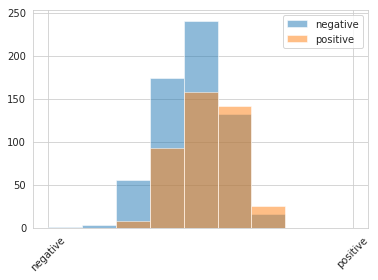

In [12]:
model_obj.visualize_goodness()

In [13]:
sig_indicies = [i for i,p in enumerate(model_obj.p_values()) if p <= .1]
sig_variables = [
        features[i]
        for i, col in enumerate(features)
        if i in sig_indicies
]

Q30
[1 2]
0.11
Q33
[1 2 3 4 5 6 7 8 9]
0.18
Q14
[1 2 3 4]
-0.12


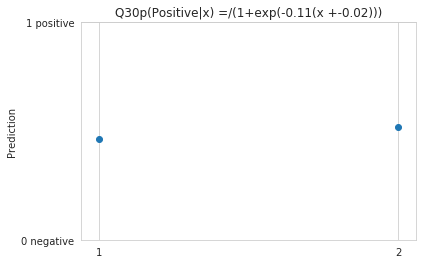

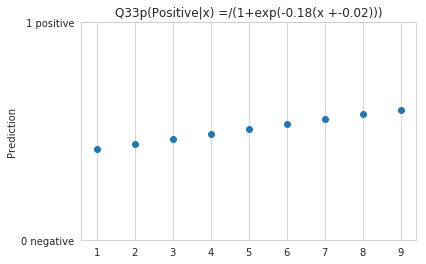

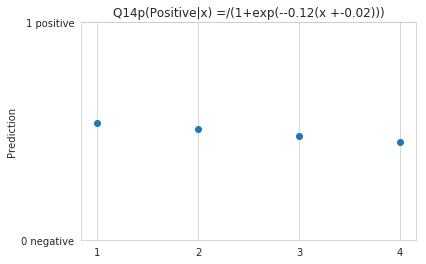

In [14]:
for sig, idx in zip(sig_variables,sig_indicies):
    if sig in continuous_independent_variables:
        print(sig)
        model_obj.simulate_continuous_outcomes(sig, idx)

Q35_Male
Q43_Donald Trump


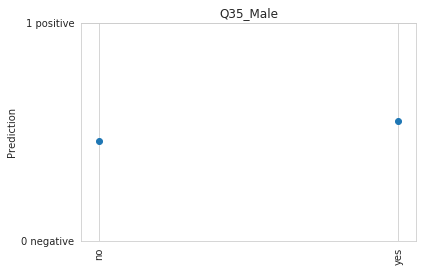

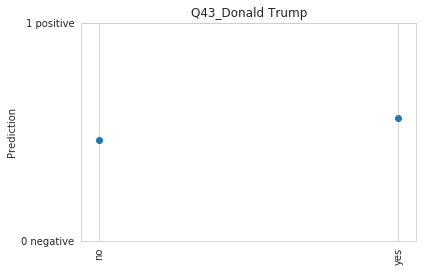

In [18]:
for sig, idx in zip(sig_variables,sig_indicies):
    if sig not in continuous_independent_variables:
        print(sig)
        model_obj.simulate_binary_outcomes(sig)